# IP Adapter + Attn Mask -> visualization (Attention map)

In [1]:
import cv2
import numpy as np
import torch
from text_diffuser.generate_mask_only import gen_bbox_mask_and_text_stroke_mask
from IPython.display import display
from PIL import Image
from text_diffuser.pipeline_text_diffuser_sd15 import StableDiffusionPipeline
from text_diffuser.t_diffusers.unet_2d_condition import UNet2DConditionModel

from diffusers import DDPMScheduler
from hi_sam.text_segmentation import make_text_segmentation_args
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import register_cross_attention_hook

td_ckpt = "GoGiants1/td-unet15"


unet = UNet2DConditionModel.from_pretrained(
    td_ckpt,
    subfolder="unet",
)

pipe = StableDiffusionPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    unet=unet,
    torch_dtype=torch.float32,
)
pipe.load_ip_adapter(
    "h94/IP-Adapter",
    subfolder=[
        "models",
        "models",
    ],
    weight_name=[
        "ip-adapter_sd15.safetensors",
        "ip-adapter_sd15.safetensors",
    ],
)
pipe.set_ip_adapter_scale(0.4)

pipe.unet = register_cross_attention_hook(pipe.unet)

input_image = Image.open("text_diffuser/assets/test01.jpeg").convert("RGB").resize((512,512))


""" Change the text in the original image by coordinates and  """

sample_text="Doge Coin"
# for original_input.jpeg. 110, 500에서 가장 가까운 mask의 글자를 바꾼다.
coordinates=[[256, 256]] 

arg_textseg = make_text_segmentation_args(
    model_type='vit_l',
    checkpoint_path='sam_tss_l_hiertext.pth',
    input_size=input_image.size,
    hier_det=False,
)

arg_maskgen = make_text_segmentation_args(
    model_type='vit_h',
    checkpoint_path='word_detection_totaltext.pth',
    input_size=input_image.size,
    hier_det=True,
)

out, tss = gen_bbox_mask_and_text_stroke_mask(input_image, sample_text=sample_text, choice_list=coordinates, arg_textseg=arg_textseg, arg_maskgen=arg_maskgen)

# out.save(f"./assets/mask_1_out.png") # for debugging
text_mask_image = cv2.cvtColor(np.array(out), cv2.COLOR_RGB2BGR)
tss_image = Image.fromarray(tss)
pipe.scheduler = DDPMScheduler.from_config(pipe.scheduler.config)
generator = torch.Generator(device="cuda").manual_seed(42)
pipe.to("cuda")
output = pipe(
    prompt="a man, poster",
    input_image=input_image,
    text_mask_image=text_mask_image,
    ip_adapter_image=[input_image, input_image],
    text_stroke_mask=tss,
    width=512,
    height=512,
    guidance_scale=7,
    generator=generator,
).images[0]


2024-05-30 14:37:47.916652: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-30 14:37:47.962480: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-30 14:37:47.962518: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-30 14:37:47.962542: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-30 14:37:47.971076: I tensorflow/core/platform/cpu_feature_g

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
num_tokens  [4, 4]
Freeze image encoder.
<All keys matched successfully>
Freeze image encoder.
<All keys matched successfully>


/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:464: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/home/s2/mlvu25/anaconda3/envs/tf/lib/python3.10/site-packages/torch/utils/checkpoint.py:91: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
100%|██████████| 4/4 [00:01<00:00,  2.52it/s]


Mask shape:  (512, 512)


  0%|          | 0/50 [00:00<?, ?it/s]

IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.0.attentions.0.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.0.attentions.1.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.1.attentions.0.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.1.attentions.1.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.2.attentions.0.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  down_blocks.2.attentions.1.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  mid_block.attentions.0.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  up_blocks.1.attentions.0.transformer_blocks.0.attn2
IP Adapter mask num  1
IP Adapter mask num  2
hook_fn:  up_blocks.1.attentions.1.transformer_blocks.0.attn2
IP Adapter mask nu

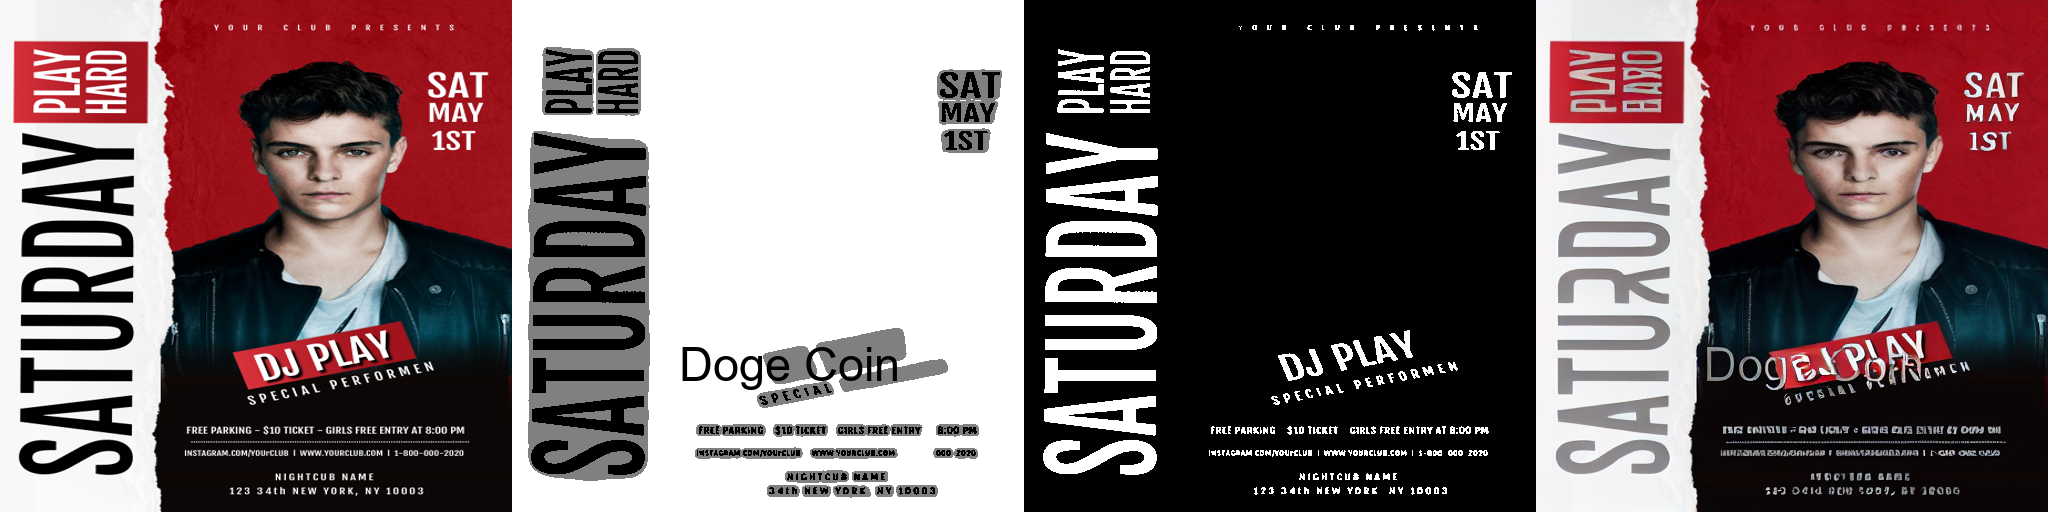

In [2]:
from diffusers.utils import make_image_grid
img_list = [input_image, out, tss_image, output]

img = make_image_grid(img_list, rows=1, cols=len(img_list))
display(img)

In [3]:
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import attn_maps, ip_attn_maps, upscale
from collections import defaultdict

def get_net_attn_map_per_epochs(image_size, batch_size=2, instance_or_negative=False, detach=True, target_processor="ip_attn"):

    idx = 0 if instance_or_negative else 1
    net_attn_maps = defaultdict(list)
    target_attn_map_dict = attn_maps if target_processor == "attn" else ip_attn_maps
    
    # print("target_attn_map_dict: ", target_attn_map_dict.keys())
    if target_processor == "ip_attn":
        for name, attn_map_list in target_attn_map_dict.items():
            print(name)
            if not attn_map_list:
                continue
            
            for i, attn_map in enumerate(attn_map_list):
                print(len(attn_map))
                print(attn_map[0].shape)
                attn_map_1 = attn_map[0].cpu() if detach else attn_map[0]
                attn_map_2 = attn_map[1].cpu() if detach else attn_map[1]
                attn_map_1 = torch.chunk(attn_map_1, batch_size)[idx]
                # .squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                attn_map_2 = torch.chunk(attn_map_2, batch_size)[idx]
                # .squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                upsacled_attn_map_1 = upscale(attn_map_1, image_size)
                upsacled_attn_map_2 = upscale(attn_map_2, image_size)
                net_attn_maps[name + "bbox"].append(upsacled_attn_map_1)
                net_attn_maps[name + "tss"].append(upsacled_attn_map_2)  
    else:
        for name, attn_map_dict in target_attn_map_dict.items():
            if attn_map_dict is None:
                continue
            else:
                attn_map = attn_map_dict # dict{inference_step: ip_attn_map_list}
            
            for _, attn_map in attn_map.items():
                attn_map = attn_map if detach else attn_map[0]
                    
                attn_map = torch.chunk(attn_map, batch_size)[idx].squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                upsacled_attn_map = upscale(attn_map, image_size)
                net_attn_maps[name].append(upsacled_attn_map)

    net_attn_maps = {key: torch.mean(torch.stack(value, dim=0), dim=0) for key, value in net_attn_maps.items()}
    return net_attn_maps

In [4]:
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import upscale_maps

def get_attn_maps_per_epochs(image_size, batch_size=2, instance_or_negative=False, detach=True, target_processor="ip_attn"):

    idx = 0 if instance_or_negative else 1
    net_attn_maps = defaultdict(list)
    target_attn_map_dict = attn_maps if target_processor == "attn" else ip_attn_maps
    
    # print("target_attn_map_dict: ", target_attn_map_dict.keys())
    if target_processor == "ip_attn":
        for name, attn_map_dict in target_attn_map_dict.items():
            if attn_map_dict is None:
                continue
            else:
                attn_map = attn_map_dict # dict{inference_step: ip_attn_map_list}
            
            for _, attn_map in attn_map.items():
                attn_map_1 = attn_map[0].cpu() if detach else attn_map[0]
                attn_map_2 = attn_map[1].cpu() if detach else attn_map[1]
                    
                attn_map_1 = torch.chunk(attn_map_1, batch_size)[idx] # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                attn_map_2 = torch.chunk(attn_map_2, batch_size)[idx] # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                upsacled_attn_map_1 = upscale_maps(attn_map_1, image_size)
                upsacled_attn_map_2 = upscale_maps(attn_map_2, image_size)
                net_attn_maps[name + "bbox"].append(upsacled_attn_map_1)
                net_attn_maps[name + "tss"].append(upsacled_attn_map_2)  
    else:
        for name, attn_map_dict in target_attn_map_dict.items():
            if attn_map_dict is None:
                continue
            else:
                attn_map = attn_map_dict # dict{inference_step: ip_attn_map_list}
            
            for _, attn_map in attn_map.items():
                attn_map = attn_map if detach else attn_map[0]
                    
                attn_map = torch.chunk(attn_map, batch_size)[idx].squeeze() # chunk의 첫번째가 bbox 마스크, 두번째가 tss 마스크
                upsacled_attn_map = upscale(attn_map, image_size)
                net_attn_maps[name].append(upsacled_attn_map)

    net_attn_maps = {key: torch.mean(torch.stack(value, dim=0), dim=0) for key, value in net_attn_maps.items()}
    return net_attn_maps

In [5]:
from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import attnmaps2images, attnmaps2rgbimages

attn_maps_dict = get_net_attn_map_per_epochs((512, 512))

print(attn_maps_dict)

down_blocks.0.attentions.0.transformer_blocks.0.attn2
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2
torch.Size([8, 4096, 4])
2

In [6]:
import os
from PIL import Image

src_image = cv2.imread("text_diffuser/assets/test01.jpeg")
src_image = cv2.cvtColor(src_image, cv2.COLOR_BGR2RGB)
attn_hots = []

for k, v in attn_maps_dict.items():
    print(k, len(v))
    out = attnmaps2images(v)
    attn_hots.append(out)
    replaced_k = k.replace(".", "_")
    for i, img in enumerate(out):
        out_path = f"./attn_maps_mask_test/{replaced_k}/attn_map_gray_{i}.png"
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        img.save(out_path)

attn_hots = []

for k, v in attn_maps_dict.items():
    print(k, len(v))
    out = attnmaps2rgbimages(v, src_image)
    attn_hots.append(out)
    replaced_k = k.replace(".", "_")
    for i, img in enumerate(out):
        out_path = f"./attn_maps_mask_test/{replaced_k}/attn_heatmap_{i}.png"
        if not os.path.exists(os.path.dirname(out_path)):
            os.makedirs(os.path.dirname(out_path))
        img.save(out_path)

down_blocks.0.attentions.0.transformer_blocks.0.attn2bbox 4
down_blocks.0.attentions.0.transformer_blocks.0.attn2tss 4
down_blocks.0.attentions.1.transformer_blocks.0.attn2bbox 4
down_blocks.0.attentions.1.transformer_blocks.0.attn2tss 4
down_blocks.1.attentions.0.transformer_blocks.0.attn2bbox 4
down_blocks.1.attentions.0.transformer_blocks.0.attn2tss 4
down_blocks.1.attentions.1.transformer_blocks.0.attn2bbox 4
down_blocks.1.attentions.1.transformer_blocks.0.attn2tss 4
down_blocks.2.attentions.0.transformer_blocks.0.attn2bbox 4
down_blocks.2.attentions.0.transformer_blocks.0.attn2tss 4
down_blocks.2.attentions.1.transformer_blocks.0.attn2bbox 4
down_blocks.2.attentions.1.transformer_blocks.0.attn2tss 4
mid_block.attentions.0.transformer_blocks.0.attn2bbox 4
mid_block.attentions.0.transformer_blocks.0.attn2tss 4
up_blocks.1.attentions.0.transformer_blocks.0.attn2bbox 4
up_blocks.1.attentions.0.transformer_blocks.0.attn2tss 4
up_blocks.1.attentions.1.transformer_blocks.0.attn2bbox 4
up

In [7]:
# from style_transfer.visualize_attention_src.ip_adapter_attn_map_utils import attn_maps, ip_attn_maps

# print(ip_attn_maps)

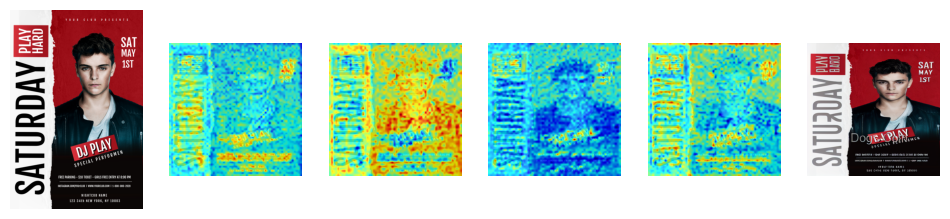

In [8]:
from matplotlib import pyplot as plt
ip_adapter_image = cv2.imread("text_diffuser/assets/test01.jpeg")
display_images = [cv2.cvtColor(ip_adapter_image, cv2.COLOR_BGR2RGB)] + attn_hots[0] + [output]
fig, axes = plt.subplots(1, len(display_images), figsize=(12, 4))
for axe, image in zip(axes, display_images):
    axe.imshow(image, cmap='gray')
    axe.axis('off')
plt.show()